In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from workflows.sql_workflow import SQLWorkflow
from models.graph_state import GraphState
from models.llm import CHATLLM, BASELLM
from utils.data_utils import load_csv_to_sqlite
from configs.examples import EXAMPLES
from configs.schemas import SCHEMAS
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langgraph.errors import GraphRecursionError
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [33]:
csv_files = {
    "data/PET_PLACES.csv": "PET_PLACES",
    "data/CHILDREN_PLACES.csv": "CHILDREN_PLACES",
}

conn = load_csv_to_sqlite(csv_files)
embeddings = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

questions = [item["question"] for item in EXAMPLES]
question_embeddings = [
    (question, embeddings.embed_query(question)) for question in questions
]
vectorstore_examples = FAISS.from_embeddings(
    text_embeddings=question_embeddings, embedding=embeddings, metadatas=EXAMPLES
)

c:\Users\jiyoo\OneDrive\PrompTart\TourGuideRAG
Loaded data/PET_PLACES.csv into table 'PET_PLACES'.
Loaded data/CHILDREN_PLACES.csv into table 'CHILDREN_PLACES'.


In [36]:
tour_rag = SQLWorkflow(
    CHATLLM, CHATLLM, conn, vectorstore_examples
)
app = tour_rag.setup_workflow()

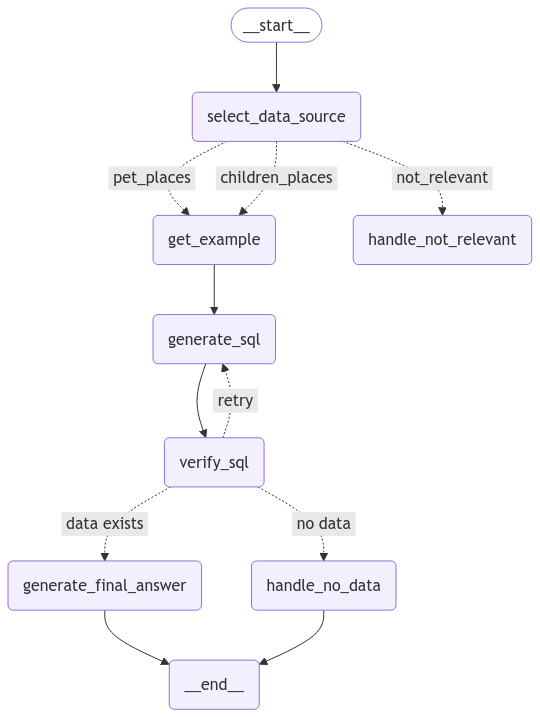

In [37]:
from IPython.display import Image, display

display(
    Image(app.get_graph(xray=True).draw_mermaid_png())
)  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다.


In [42]:
initial_state = GraphState(
    question="종로구에 무료 주차되는 미술관 알려줘",
)

try:
    result = app.invoke(initial_state, {"recursion_limit": 7})
    print('\n', result["answer"])
except GraphRecursionError:
    print("에러가 발생했습니다. 다시 시도해주세요.")

children_places
<QUESTION> 서울시 도봉구에 있는 무료 주차 가능한 전시 공간을 추천해주세요. </QUESTION>
<SQL> SELECT * FROM children_places WHERE CTPRVN_NM = '서울특별시' AND SIGNGU_NM = '도봉구' AND CTGRY_ONE_NM LIKE '%전시%' AND FRE_PARKNG_AT = 'Y' </SQL>

<QUESTION> 경기도에 위치한 무료 주차가 가능한 놀이공원을 알려주세요. </QUESTION>
<SQL> SELECT * FROM children_places WHERE CTPRVN_NM = '경기도' AND CTGRY_ONE_NM = '놀이공원' AND FRE_PARKNG_AT = 'Y' </SQL>

<QUESTION> 서울 강동구에서 수유실이 있는 미술관을 추천해주세요. </QUESTION>
<SQL> SELECT * FROM children_places WHERE CTPRVN_NM = '서울특별시' AND SIGNGU_NM = '강동구' AND CTGRY_THREE_NM LIKE '%미술관%' AND NRSGRM_AT = 'Y' </SQL>

 <SQL> SELECT * FROM CHILDREN_PLACES WHERE CTPRVN_NM = '서울특별시' AND SIGNGU_NM = '종로구' AND CTGRY_THREE_NM LIKE '%미술관%' AND FRE_PARKNG_AT = 'Y' </SQL>
Data Length:  19

 종로구에 위치한 무료 주차가 가능한 미술관은 다음과 같습니다:

1. 금보성아트센터: 주소는 서울특별시 종로구 평창36길 20이며, 운영 시간은 일요일 11:00~18:00입니다. 무료 주차가 가능하며, 입장료는 없습니다. 자세한 정보는 페이스북 페이지(https://www.facebook.com/kbs5699)를 참조하실 수 있습니다.

2. 김종영미술관: 주소는 서울특별시 종로구 평창32길 30이며, 운영 시간은 [3-10월